<a href="https://colab.research.google.com/github/RO-AD/waymo-od-motion-pred/blob/main/tutorial/2_waymo_official_tutorial/gp-waymo_official_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waymo 공식 튜토리얼 실습

공식 튜토리얼이 오류가 좀 있어서 과거의 나에게 힘을 좀 빌렸다. 내맘대로 바꿔버리는 튜토리얼,,,ㅋ

- Waymo 공식 튜토리얼 : https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial_motion.ipynb

- 과거의 재승 : https://github.com/RO-AD/waymo-od-motion-pred/blob/b0b831d8a54531056289b85fb91b509a78bd1a20/jaeseung/tutorial-1.ipynb

# 패키지 설치

## waymo_open_dataset 패키지 설치하기

In [1]:
%%capture
!rm -rf waymo-od > /dev/null # 레포가 이미 존재하면 지움
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git checkout remotes/origin/master

In [37]:
%%capture
!pip3 install --upgrade pip
!pip3 install waymo-open-dataset-tf-2-6-0
!pip install keras==2.6 # 튜토리얼에 맞게 케라스 버전 맞춰주어야 함

## Read one frame
하나의 프레임을 읽어보자. 파일이 어떻게 생겼고, 어떻게 읽을 수 있는지 알아본다

In [3]:
!ls -al ./waymo-od/tutorial/frames

-rw-r--r-- 1 root root 8577921 Apr 11 09:51 ./waymo-od/tutorial/frames


In [4]:
!xxd ./waymo-od/tutorial/frames | head

00000000: ae5a 4100 0000 0000 e0a5 4a4b 0aa8 150a  .ZA.......JK....
00000010: 2631 3130 3034 3638 3537 3339 3731 3435  &110046857397145
00000020: 3030 3232 305f 3233 3030 5f30 3030 5f32  00220_2300_000_2
00000030: 3332 305f 3030 3012 ee01 0801 11dd ef9b  320_000.........
00000040: bf1c 0fa0 4011 ddef 9bbf 1c0f a040 11d8  ....@........@..
00000050: 5892 7f42 5d8d 4011 e81f 42d4 9308 8440  X..B].@...B....@
00000060: 118f b145 4fb9 8ba0 3f11 41c3 45a9 0592  ...EO...?.A.E...
00000070: d4bf 11ba 4ac5 6e55 fe49 3f11 85b3 7881  ....J.nU.I?...x.
00000080: 2a81 44bf 1100 0000 0000 0000 001a 9001  *.D.............
00000090: 0935 29b1 f11e ffef 3f09 0c0a 38a1 558c  .5).....?...8.U.


In [5]:
import tensorflow.compat.v1 as tf

# Eager Execution 모드 활성화 -> 디버깅 용이 및 코드 실행속도 향상
tf.enable_eager_execution()

import numpy as np
from waymo_open_dataset import dataset_pb2 # pb : protocol buffers

FILENAME = '/content/waymo-od/tutorial/frames' # git repo 내에 있음
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
    frame = dataset_pb2.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

In [6]:
from waymo_open_dataset.utils import  frame_utils

(range_images, camera_projections, _, range_image_top_pose)\
  = frame_utils.parse_range_image_and_camera_projection(frame)

# 데이터셋 로드

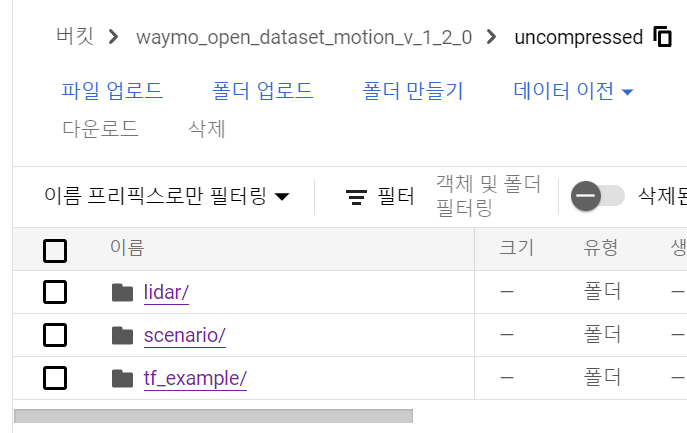

클라우드에 저장되어있는 데이터셋을 확인해보면 위와 같이 크게 세 종류로 구성되어있는데, lidar는 올해 새로 생긴 라이다 데이터이며, scenario와 tf_example이 map, agent 등 다양한 데이터가 담긴 데이터셋이다.

scenario는 라이브러리 내에 선언되어있는 proto 구조로 파싱 가능한 데이터이며, tf_example은 tf에서 다루기 좋은 구조로 이루어진 데이터다. 동일한 구조라고 한다.

튜토리얼은 tf_example 데이터로 진행되기 때문에, 이 데이터를 사용한다.

*처음에 scenario 데이터로 하다가 수많은 오류와 맞이하여 미친듯이 삽질을 했다는,,,아래 이슈들을 통해 오류를 해결해나갔다.*
- https://github.com/waymo-research/waymo-open-dataset/issues/258
  - 파싱이 안된다는 이슈.
  - tf_example 데이터셋을 사용하라는 답변.
- https://github.com/waymo-research/waymo-open-dataset/issues/617
  - tf_example로 했는데도 파싱이 안되는 이슈
  - roadgraph_samples의 최대 포인트 수가 잘못됨. 20k -> 30k

## Google Drive 연동
일단 테스트용도로 validation 5개를 drive에 업로드 했다. 이를 가져온다.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp -r /content/drive/MyDrive/waymo-od-dataset/waymo_open_dataset_motion_v_1_2_0/uncompressed/tf_example ./

In [9]:
!ls -al ./tf_example/

total 583836
drwx------ 2 root root      4096 Apr 11 09:54 .
drwxr-xr-x 1 root root      4096 Apr 11 09:54 ..
-rw------- 1 root root 597834382 Apr 11 09:54 uncompressed_tf_example_validation_validation_tfexample.tfrecord-00000-of-00150


## python 코드로 데이터셋 읽기

데이터셋의 양이 너무 많고 크기 때문에, 데이터셋도 효율적으로 관리할 필요가 있다. Tensorflow는 TFRecord라는 형태의 파일로 관리할 수 있도록 하는데, 구조를 최소한으로 압축해서 보관하는 방식이다.

TFRecordDataset() 메소드는 이러한 TFRecord 형태의 데이터셋을 다룰 수 있도록 하는 메소드다.

In [10]:
FILENAME = './tf_example/uncompressed_tf_example_validation_validation_tfexample.tfrecord-00000-of-00150'

In [11]:
import tensorflow as tf

dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [12]:
for num_data, data in enumerate(dataset):
    pass

num_data

332

하나의 tfrecord 파일 내부에는 332개의 데이터가 있는 것을 알 수 있다.

## 데이터셋 파싱

데이터셋 구조를 선언하고, 파싱한다.

In [13]:

# Example field definition
roadgraph_features = {
    'roadgraph_samples/dir':
        tf.io.FixedLenFeature([30000, 3], tf.float32, default_value=None),
    'roadgraph_samples/id':
        tf.io.FixedLenFeature([30000, 1], tf.int64, default_value=None),
    'roadgraph_samples/type':
        tf.io.FixedLenFeature([30000, 1], tf.int64, default_value=None),
    'roadgraph_samples/valid':
        tf.io.FixedLenFeature([30000, 1], tf.int64, default_value=None),
    'roadgraph_samples/xyz':
        tf.io.FixedLenFeature([30000, 3], tf.float32, default_value=None),
}

# Features of other agents.
state_features = {
    'state/id':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/type':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/is_sdc':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/tracks_to_predict':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/current/bbox_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/height':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/length':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/timestamp_micros':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/valid':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/vel_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/width':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/z':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/future/bbox_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/height':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/length':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/timestamp_micros':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/valid':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/vel_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/width':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/z':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/past/bbox_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/height':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/length':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/timestamp_micros':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/valid':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/vel_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/width':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/z':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
}

traffic_light_features = {
    'traffic_light_state/current/state':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/valid':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/x':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/y':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/z':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/past/state':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/valid':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/x':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/y':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/z':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
}

features_description = {}
features_description.update(roadgraph_features)
features_description.update(state_features)
features_description.update(traffic_light_features)

In [14]:
FILENAME = './tf_example/uncompressed_tf_example_validation_validation_tfexample.tfrecord-00000-of-00150'

dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
data = next(dataset.as_numpy_iterator())
parsed = tf.io.parse_single_example(data, features_description)

# 시각화 이미지 생성

In [15]:
import uuid
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.display import HTML

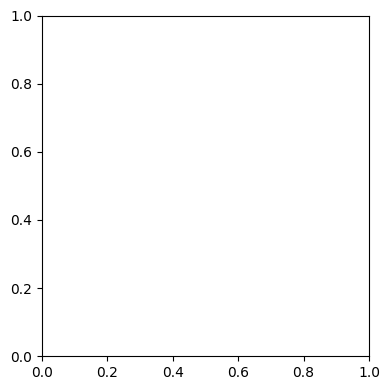

In [16]:
class Painter:
  """ 데이터 시각화에 matplotlib를 이용하기 위해 일부 과정 함수화 """

  def __init__(self, debug=False):
    if debug:
      fig, ax = self.create_figure_and_axes(400)
      self.fig_canvas_image(fig)

  def create_figure_and_axes(self, size_pixels=1000):
    """ figure, axes 초기화."""
    # figure와 axes 객체 생성
    fig, ax = plt.subplots(1, 1, num=uuid.uuid4())

    # 픽셀로 설정할 수 있도록 변경
    dpi = 100
    size_inches = size_pixels / dpi
    fig.set_size_inches([size_inches, size_inches])
    fig.set_dpi(dpi)

    # 배경색 흰색으로 설정
    fig.set_facecolor('white')
    ax.set_facecolor('white')

    # x,y축 라벨과 선 색상을 검은색으로 설정
    ax.xaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='y', colors='black')

    # subplot들 간 간격을 자동으로 조절
    fig.set_tight_layout(True)

    # 그리드 안보이도록 설정
    ax.grid(False)
    
    return fig, ax

  def fig_canvas_image(self, fig):
    """ fig를 이미지로 변환
    
    fig.canvas.tostring_rgb()를 이용하여 [H, W, 3] uint8 np.array 이미지를 반환
    """

    # xticks와 yticks를 표시하기에 충분한 마진 부여
    fig.subplots_adjust(
        left=0.08, bottom=0.08, right=0.98, top=0.98, wspace=0.0, hspace=0.0)
    
    # canvas에 그림 그리기
    fig.canvas.draw()

    # np.frombuffer 함수로 이미지 데이터를 uint8 형태로 변환
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)

    # 데이터를 (높이, 너비, 채널 수) 형태로 변경하여 반환
    return data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

Painter(debug=True)

In [17]:
class VizDatasetProcessor:
  def __init__(self, decoded_example, debug=False):
    self.raw_data = decoded_example

    self.set_seperate_states() # state를 과거/현재/미래로 분리
    self.set_other_variables() # 기타 정보들을 정리 및 변수 설정
    
  def set_seperate_states(self):
    """ state를 과거/현재/미래로 분리 """

    # 과거 state 데이터 : [num_agents, num_past_steps, 2] float32.
    self.past_states = tf.stack(
        [self.raw_data['state/past/x'],
         self.raw_data['state/past/y']],
        -1).numpy()
    self.past_states_mask = self.raw_data['state/past/valid'].numpy() > 0.0

    # 현재 state 데이터 : [num_agents, 1, 2] float32.
    self.current_states = tf.stack(
        [self.raw_data['state/current/x'],
         self.raw_data['state/current/y']],
        -1).numpy()
    self.current_states_mask = self.raw_data['state/current/valid'].numpy() > 0.0

    # 미래 state 데이터 : [num_agents, num_future_steps, 2] float32.
    self.future_states = tf.stack(
        [self.raw_data['state/future/x'],
         self.raw_data['state/future/y']],
        -1).numpy()
    self.future_states_mask = self.raw_data['state/future/valid'].numpy() > 0.0
  
  def set_other_variables(self):
    """ 기타 정보들을 정리 및 변수 설정 """  

    # 도로 정보
    self.roadgraph_xyz = self.raw_data['roadgraph_samples/xyz'].numpy()

    # agent 수, 과거 step 수, 미래 step 수
    self.num_agents, self.num_past_steps, _ = self.past_states.shape
    self.num_future_steps = self.future_states.shape[1]

    # agent 별 색상값 설정 
    self.color_map = self._get_colormap(self.num_agents)

    # 전체 데이터의 중심점 구하기
    self.center_y, self.center_x, self.width = self._get_viewport()
  
  def _get_viewport(self):
    """ 전체 데이터의 중심점 구하기

    Returns:
      center_y: float. y coordinate for center of data.
      center_x: float. x coordinate for center of data.
      width: float. Width of data.
    """
    # 모든 state 배열
    # : [num_agens, num_past_steps + 1 + num_future_steps, depth] float32.
    all_states = np.concatenate([
        self.past_states,
        self.current_states,
        self.future_states], 1)
    # mask
    # : [num_agens, num_past_steps + 1 + num_future_steps] float32.
    all_states_mask = np.concatenate([
        self.past_states_mask,
        self.current_states_mask,
        self.future_states_mask], 1)

    valid_states = all_states[all_states_mask]
    all_y = valid_states[..., 1]
    all_x = valid_states[..., 0]

    center_y = (np.max(all_y) + np.min(all_y)) / 2
    center_x = (np.max(all_x) + np.min(all_x)) / 2

    range_y = np.ptp(all_y)
    range_x = np.ptp(all_x)

    width = max(range_y, range_x)

    return center_y, center_x, width

  
  def _get_colormap(self, num_agents):
    """ agent 개수만큼 랜덤하게 colormap 생성 """
    colors = cm.get_cmap('jet', num_agents)
    colors = colors(range(num_agents))
    np.random.shuffle(colors)
    return colors

In [18]:
class Visualizer:
  def __init__(self, decoded_example, size_pixels=400, debug=False):
    self.debug = debug
    self.size_pixels = size_pixels
    self.dataset = VizDatasetProcessor(decoded_example)
    self.painter = Painter()
    
  def run(self):
    images = self.get_all_step_images()
    if self.debug:
      images = images[::5]
    self.anim = self.create_animation(images)
    return self.anim
  
  def create_animation(self, images):
    """ Creates a Matplotlib animation of the given images.

    Args:
      images: A list of numpy arrays representing the images.

    Returns:
      A matplotlib.animation.Animation.

    Usage:
      anim = create_animation(images)
      anim.save('/tmp/animation.avi')
      HTML(anim.to_html5_video())
    """

    plt.ioff()
    fig, ax = plt.subplots()
    dpi = 100
    size_inches = self.size_pixels / dpi
    fig.set_size_inches([size_inches, size_inches])
    plt.ion()

    def animate_func(i):
      ax.imshow(images[i])
      ax.set_xticks([])
      ax.set_yticks([])
      ax.grid('off')

    anim = animation.FuncAnimation(
        fig, animate_func, frames=len(images) // 2, interval=100)
    plt.close(fig)
    return anim


  def get_all_step_images(self):
    """ 각 steps의 이미지를 리스트로 반환하는 함수 """
    images = []

    # 과거
    for i, (s, m) in enumerate(
        zip(
            np.split(self.dataset.past_states, self.dataset.num_past_steps, 1),
            np.split(self.dataset.past_states_mask, self.dataset.num_past_steps, 1))):
      im = self._visualize_one_step(s[:, 0], m[:, 0],
                              'past: %d' % (self.dataset.num_past_steps - i))
      images.append(im)

    # 현재
    s = self.dataset.current_states
    m = self.dataset.current_states_mask

    im = self._visualize_one_step(s[:, 0], m[:, 0], 'current')
    images.append(im)

    # 미래
    for i, (s, m) in enumerate(
        zip(
            np.split(self.dataset.future_states, self.dataset.num_future_steps, 1),
            np.split(self.dataset.future_states_mask, self.dataset.num_future_steps, 1))):
      im = self._visualize_one_step(s[:, 0], m[:, 0],
                              'future: %d' % (i + 1))
      images.append(im)

    return images


  def _visualize_one_step(self,
                          states,
                          mask,
                          title):
    """Generate visualization for a single step."""

    center_y = self.dataset.center_y
    center_x = self.dataset.center_x
    width    = self.dataset.width


    # Create figure and axes.
    fig, ax = self.painter.create_figure_and_axes(size_pixels=self.size_pixels)

    # Plot roadgraph.
    rg_pts = self.dataset.roadgraph_xyz[:, :2].T
    ax.plot(rg_pts[0, :], rg_pts[1, :], 'k.', alpha=1, ms=2)

    masked_x = states[:, 0][mask]
    masked_y = states[:, 1][mask]
    colors = self.dataset.color_map[mask]

    # Plot agent current position.
    ax.scatter(
        masked_x,
        masked_y,
        marker='o',
        linewidths=3,
        color=colors,
    )

    # Title.
    ax.set_title(title)

    # Set axes.  Should be at least 10m on a side and cover 160% of agents.
    size = max(10, width * 1.0)
    ax.axis([
        -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
        size / 2 + center_y
    ])
    ax.set_aspect('equal')

    image = self.painter.fig_canvas_image(fig)
    plt.close(fig)

    return image



In [19]:
viz = Visualizer(parsed, debug=True)

<ipython-input-17-902c7c9f4437>:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('jet', num_agents)


In [20]:
anim = viz.run()

In [21]:
# HTML(viz.anim.to_html5_video()) # 영상 보려면 주석 해제

# Simple MLP로 학습시켜보기 (with. TF)



문제 자체가 복잡해서 간단한 MLP로는 택도 없지만 일단 모델을 만들어보면서 감을 익혀본다

In [22]:
import tensorflow as tf

FILENAME = './tf_example/uncompressed_tf_example_validation_validation_tfexample.tfrecord-00000-of-00150'

dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
data = next(dataset.as_numpy_iterator())

### Input data 구성하기

**tf.io.parse_single_example** 함수로 파싱한 데이터(decoded_example)는 속성별로 정리되어있다. 즉, 하나의 리스트에 `[agent1_feature, agent2_feature, ...]`와 같이 agent 별로 묶여있지 않다.

모델에 agent 데이터를 한번에 넣어주기 위해 여러 feature를 **tf.stack**으로 묶되, **axis를 -1로 설정**해서 agent별로 묶이도록 수정해준다.

In [82]:
def _parse(value):
  """ 데이터를 파싱해서 Input을 만드는 함수 """
  decoded_example = tf.io.parse_single_example(value, features_description)

  # 모델 별 과거 state
  past_states = tf.stack([
      decoded_example['state/past/x'], decoded_example['state/past/y'],
      decoded_example['state/past/length'], decoded_example['state/past/width'],
      decoded_example['state/past/bbox_yaw'],
      decoded_example['state/past/velocity_x'],
      decoded_example['state/past/velocity_y']
  ], -1)

  # 모델 별 현재 state
  cur_states = tf.stack([
      decoded_example['state/current/x'], decoded_example['state/current/y'],
      decoded_example['state/current/length'],
      decoded_example['state/current/width'],
      decoded_example['state/current/bbox_yaw'],
      decoded_example['state/current/velocity_x'],
      decoded_example['state/current/velocity_y']
  ], -1)

  # 과거 + 현재 => Input
  # shape : [agent 수(128), state 수(10+1==11), feature 수(7)]
  input_states = tf.concat([past_states, cur_states], 1)
  input_states = input_states[..., :2]

  # 모델 별 미래 state
  future_states = tf.stack([
      decoded_example['state/future/x'], decoded_example['state/future/y'],
      decoded_example['state/future/length'],
      decoded_example['state/future/width'],
      decoded_example['state/future/bbox_yaw'],
      decoded_example['state/future/velocity_x'],
      decoded_example['state/future/velocity_y']
  ], -1)

  gt_future_states = tf.concat([past_states, cur_states, future_states], 1)

  past_is_valid = decoded_example['state/past/valid'] > 0
  current_is_valid = decoded_example['state/current/valid'] > 0
  future_is_valid = decoded_example['state/future/valid'] > 0
  gt_future_is_valid = tf.concat(
      [past_is_valid, current_is_valid, future_is_valid], 1)

  # If a sample was not seen at all in the past, we declare the sample as
  # invalid.
  sample_is_valid = tf.reduce_any(
      tf.concat([past_is_valid, current_is_valid], 1), 1)

  inputs = {
      'input_states': input_states,
      'gt_future_states': gt_future_states,
      'gt_future_is_valid': gt_future_is_valid,
      'object_type': decoded_example['state/type'],
      'tracks_to_predict': decoded_example['state/tracks_to_predict'] > 0,
      'sample_is_valid': sample_is_valid,
  }
  return inputs


dataset = tf.data.TFRecordDataset(FILENAME)
data = next(dataset.as_numpy_iterator())
_parse(data)

(128, 11, 7)
(128, 11, 2)


{'input_states': <tf.Tensor: shape=(128, 11, 2), dtype=float32, numpy=
 array([[[ 2.7297551e+03, -1.3338293e+03],
         [ 2.7303794e+03, -1.3341000e+03],
         [ 2.7310159e+03, -1.3343777e+03],
         ...,
         [ 2.7350720e+03, -1.3361925e+03],
         [ 2.7357754e+03, -1.3365101e+03],
         [ 2.7364875e+03, -1.3368364e+03]],
 
        [[ 2.7063877e+03, -1.3184196e+03],
         [ 2.7063823e+03, -1.3184048e+03],
         [ 2.7063889e+03, -1.3184080e+03],
         ...,
         [ 2.7062402e+03, -1.3183809e+03],
         [ 2.7061956e+03, -1.3183558e+03],
         [ 2.7061311e+03, -1.3183352e+03]],
 
        [[ 2.6751304e+03, -1.3161355e+03],
         [ 2.6752441e+03, -1.3162169e+03],
         [ 2.6753342e+03, -1.3163317e+03],
         ...,
         [ 2.6761272e+03, -1.3171147e+03],
         [ 2.6762427e+03, -1.3172480e+03],
         [ 2.6763604e+03, -1.3173755e+03]],
 
        ...,
 
        [[-1.0000000e+00, -1.0000000e+00],
         [-1.0000000e+00, -1.0000000e+00],
   

### 모델 성능 평가를 위한 Metrics 구성하기

In [48]:
from google.protobuf import text_format
from waymo_open_dataset.protos import motion_metrics_pb2

def _default_metrics_config():
  config = motion_metrics_pb2.MotionMetricsConfig()
  config_text = """
  track_steps_per_second: 10
  prediction_steps_per_second: 2
  track_history_samples: 10
  track_future_samples: 80
  speed_lower_bound: 1.4
  speed_upper_bound: 11.0
  speed_scale_lower: 0.5
  speed_scale_upper: 1.0
  step_configurations {
    measurement_step: 5
    lateral_miss_threshold: 1.0
    longitudinal_miss_threshold: 2.0
  }
  step_configurations {
    measurement_step: 9
    lateral_miss_threshold: 1.8
    longitudinal_miss_threshold: 3.6
  }
  step_configurations {
    measurement_step: 15
    lateral_miss_threshold: 3.0
    longitudinal_miss_threshold: 6.0
  }
  max_predictions: 6
  """
  text_format.Parse(config_text, config)
  return config

In [49]:
metrics_config = _default_metrics_config()
metrics_config

track_steps_per_second: 10
prediction_steps_per_second: 2
track_history_samples: 10
track_future_samples: 80
speed_lower_bound: 1.399999976158142
speed_upper_bound: 11.0
speed_scale_lower: 0.5
speed_scale_upper: 1.0
step_configurations {
  measurement_step: 5
  lateral_miss_threshold: 1.0
  longitudinal_miss_threshold: 2.0
}
step_configurations {
  measurement_step: 9
  lateral_miss_threshold: 1.7999999523162842
  longitudinal_miss_threshold: 3.5999999046325684
}
step_configurations {
  measurement_step: 15
  lateral_miss_threshold: 3.0
  longitudinal_miss_threshold: 6.0
}
max_predictions: 6

In [50]:
from waymo_open_dataset.metrics.ops import py_metrics_ops

class MotionMetrics(tf.keras.metrics.Metric):
  """Wrapper for motion metrics computation."""

  def __init__(self, config):
    super().__init__()
    self._prediction_trajectory = []
    self._prediction_score = []
    self._ground_truth_trajectory = []
    self._ground_truth_is_valid = []
    self._prediction_ground_truth_indices = []
    self._prediction_ground_truth_indices_mask = []
    self._object_type = []
    self._metrics_config = config

  def reset_state(self):
    self._prediction_trajectory = []
    self._prediction_score = []
    self._ground_truth_trajectory = []
    self._ground_truth_is_valid = []
    self._prediction_ground_truth_indices = []
    self._prediction_ground_truth_indices_mask = []
    self._object_type = []

  def update_state(self, prediction_trajectory, prediction_score,
                   ground_truth_trajectory, ground_truth_is_valid,
                   prediction_ground_truth_indices,
                   prediction_ground_truth_indices_mask, object_type):
    self._prediction_trajectory.append(prediction_trajectory)
    self._prediction_score.append(prediction_score)
    self._ground_truth_trajectory.append(ground_truth_trajectory)
    self._ground_truth_is_valid.append(ground_truth_is_valid)
    self._prediction_ground_truth_indices.append(
        prediction_ground_truth_indices)
    self._prediction_ground_truth_indices_mask.append(
        prediction_ground_truth_indices_mask)
    self._object_type.append(object_type)

  def result(self):
    # [batch_size, num_preds, 1, 1, steps, 2].
    # The ones indicate top_k = 1, num_agents_per_joint_prediction = 1.
    prediction_trajectory = tf.concat(self._prediction_trajectory, 0)
    # [batch_size, num_preds, 1].
    prediction_score = tf.concat(self._prediction_score, 0)
    # [batch_size, num_agents, gt_steps, 7].
    ground_truth_trajectory = tf.concat(self._ground_truth_trajectory, 0)
    # [batch_size, num_agents, gt_steps].
    ground_truth_is_valid = tf.concat(self._ground_truth_is_valid, 0)
    # [batch_size, num_preds, 1].
    prediction_ground_truth_indices = tf.concat(
        self._prediction_ground_truth_indices, 0)
    # [batch_size, num_preds, 1].
    prediction_ground_truth_indices_mask = tf.concat(
        self._prediction_ground_truth_indices_mask, 0)
    # [batch_size, num_agents].
    object_type = tf.cast(tf.concat(self._object_type, 0), tf.int64)

    # We are predicting more steps than needed by the eval code. Subsample.
    interval = (
        self._metrics_config.track_steps_per_second //
        self._metrics_config.prediction_steps_per_second)
    prediction_trajectory = prediction_trajectory[...,
                                                  (interval - 1)::interval, :]

    return py_metrics_ops.motion_metrics(
        config=self._metrics_config.SerializeToString(),
        prediction_trajectory=prediction_trajectory,
        prediction_score=prediction_score,
        ground_truth_trajectory=ground_truth_trajectory,
        ground_truth_is_valid=ground_truth_is_valid,
        prediction_ground_truth_indices=prediction_ground_truth_indices,
        prediction_ground_truth_indices_mask=prediction_ground_truth_indices_mask,
        object_type=object_type)

In [51]:
metrics_config = _default_metrics_config()
motion_metrics = MotionMetrics(metrics_config)
motion_metrics

In [52]:
from waymo_open_dataset.metrics.python import config_util_py as config_util

metric_names = config_util.get_breakdown_names_from_motion_config(
    metrics_config)

metric_names

['TYPE_VEHICLE_5',
 'TYPE_VEHICLE_9',
 'TYPE_VEHICLE_15',
 'TYPE_PEDESTRIAN_5',
 'TYPE_PEDESTRIAN_9',
 'TYPE_PEDESTRIAN_15',
 'TYPE_CYCLIST_5',
 'TYPE_CYCLIST_9',
 'TYPE_CYCLIST_15']

### 모델 만들기

In [53]:
class SimpleModel(tf.keras.Model):
  """A simple one-layer regressor."""

  def __init__(self, num_agents_per_scenario, num_states_steps,
               num_future_steps):
    super(SimpleModel, self).__init__()
    self._num_agents_per_scenario = num_agents_per_scenario
    self._num_states_steps = num_states_steps
    self._num_future_steps = num_future_steps
    self.regressor = tf.keras.layers.Dense(num_future_steps * 2)

  def call(self, states):
    states = tf.reshape(states, (-1, self._num_states_steps * 2))
    pred = self.regressor(states)
    pred = tf.reshape(
        pred, [-1, self._num_agents_per_scenario, self._num_future_steps, 2])
    return pred

model = SimpleModel(
          num_agents_per_scenario=128,
          num_states_steps=11,
          num_future_steps=80)

### 학습 함수 만들기

In [54]:
def train_step(inputs):
  with tf.GradientTape() as tape:
    # [batch_size, num_agents, D]
    states = inputs['input_states']

    # Predict. [batch_size, num_agents, steps, 2].
    pred_trajectory = model(states, training=True)

    # Set training target.
    prediction_start = metrics_config.track_history_samples + 1

    # [batch_size, num_agents, steps, 7]
    gt_trajectory = inputs['gt_future_states']
    gt_targets = gt_trajectory[..., prediction_start:, :2]

    # [batch_size, num_agents, steps]
    gt_is_valid = inputs['gt_future_is_valid']
    # [batch_size, num_agents, steps]
    weights = (
        tf.cast(inputs['gt_future_is_valid'][..., prediction_start:],
                tf.float32) *
        tf.cast(inputs['tracks_to_predict'][..., tf.newaxis], tf.float32))

    loss_value = loss_fn(gt_targets, pred_trajectory, sample_weight=weights)
    
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # [batch_size, num_agents, steps, 2] ->
  # [batch_size, num_agents, 1, 1, steps, 2].
  # The added dimensions are top_k = 1, num_agents_per_joint_prediction = 1.
  pred_trajectory = pred_trajectory[:, :, tf.newaxis, tf.newaxis]

  # Fake the score since this model does not generate any score per predicted
  # trajectory.
  pred_score = tf.ones(shape=tf.shape(pred_trajectory)[:3])

  # [batch_size, num_agents].
  object_type = inputs['object_type']

  # [batch_size, num_agents].
  batch_size = tf.shape(inputs['tracks_to_predict'])[0]
  num_samples = tf.shape(inputs['tracks_to_predict'])[1]

  pred_gt_indices = tf.range(num_samples, dtype=tf.int64)
  # [batch_size, num_agents, 1].
  pred_gt_indices = tf.tile(pred_gt_indices[tf.newaxis, :, tf.newaxis],
                            (batch_size, 1, 1))
  # [batch_size, num_agents, 1].
  pred_gt_indices_mask = inputs['tracks_to_predict'][..., tf.newaxis]

  motion_metrics.update_state(pred_trajectory, pred_score, gt_trajectory,
                              gt_is_valid, pred_gt_indices,
                              pred_gt_indices_mask, object_type)

  return loss_value

### 학습하기

In [66]:
import time

dataset = tf.data.TFRecordDataset(FILENAME)
dataset = dataset.map(_parse)
dataset = dataset.batch(32)

model = SimpleModel(128, 11, 80)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()

epochs = 20
num_batches_per_epoch = 10

for epoch in range(epochs):
  print('\nStart of epoch %d' % (epoch,))
  start_time = time.time()

  # Iterate over the batches of the dataset.
  for step, batch in enumerate(dataset):
    loss_value = train_step(batch)

    # Log every 10 batches.
    if step % 10 == 0:
      print('Training loss (for one batch) at step %d: %.4f' %
            (step, float(loss_value)))
      print('Seen so far: %d samples' % ((step + 1) * 64))

    if step >= num_batches_per_epoch:
      break
  
  continue
  # Display metrics at the end of each epoch.
  train_metric_values = motion_metrics.result()
  for i, m in enumerate(
      ['min_ade', 'min_fde', 'miss_rate', 'overlap_rate', 'map']):
    for j, n in enumerate(metric_names):
      print('{}/{}: {}'.format(m, n, train_metric_values[i, j]))


Start of epoch 0
Training loss (for one batch) at step 0: 2721793.7500
Seen so far: 64 samples
Training loss (for one batch) at step 10: 898792.8125
Seen so far: 704 samples

Start of epoch 1
Training loss (for one batch) at step 0: 2220216.5000
Seen so far: 64 samples
Training loss (for one batch) at step 10: 711663.1250
Seen so far: 704 samples

Start of epoch 2
Training loss (for one batch) at step 0: 1835530.2500
Seen so far: 64 samples
Training loss (for one batch) at step 10: 557186.9375
Seen so far: 704 samples

Start of epoch 3
Training loss (for one batch) at step 0: 1506777.3750
Seen so far: 64 samples
Training loss (for one batch) at step 10: 433905.0000
Seen so far: 704 samples

Start of epoch 4
Training loss (for one batch) at step 0: 1228006.7500
Seen so far: 64 samples
Training loss (for one batch) at step 10: 337150.0000
Seen so far: 704 samples

Start of epoch 5
Training loss (for one batch) at step 0: 993993.1875
Seen so far: 64 samples
Training loss (for one batch) 

In [58]:
train_metric_values

<tf.Tensor: shape=(5, 9), dtype=float32, numpy=
array([[6.7218911e+03, 6.6020376e+03, 6.2157563e+03, 6.5875356e+03,
        6.4545649e+03, 6.0878892e+03, 5.3605879e+03, 5.2923281e+03,
        4.9972246e+03],
       [8.0004863e+03, 5.0152979e+03, 4.9419810e+03, 7.7843931e+03,
        4.7506577e+03, 4.5863999e+03, 6.7735498e+03, 4.6196099e+03,
        5.1372729e+03],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)>

In [65]:
py_metrics_ops.metrics_module.__dir__()

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__builtins__',
 'collections',
 'pywrap_tfe',
 '_context',
 '_core',
 '_execute',
 '_dtypes',
 '_op_def_registry',
 '_ops',
 '_op_def_library',
 'deprecated_endpoints',
 '_dispatch',
 'tf_export',
 'TypeVar',
 '_DetectionMetricsOutput',
 'detection_metrics',
 'DetectionMetrics',
 'detection_metrics_eager_fallback',
 '_MotionMetricsOutput',
 'motion_metrics',
 'MotionMetrics',
 'motion_metrics_eager_fallback',
 '_TrackingMetricsOutput',
 'tracking_metrics',
 'TrackingMetrics',
 'tracking_metrics_eager_fallback',
 '_IS_TENSORFLOW_PLUGIN']

In [ ]:
# tutorial/2_waymo_official_tutorial/gp-waymo_official_tutorial.ipynb